# Анализ бизнес-показателей Яндекс Афиши

Учебная работа. Самостоятельный исследовательский проект в рамках курса "Аналитик данных" Яндекс.Практикума  
Спринт 7 "Анализ бизнес показателей".
 
## Общая информация о проекте
### Описание задания
Нужно помочь маркетологам Яндекс Афиши определить, какие источники трафика менее выгодны, и как можно перераспределить бюджет, чтобы снизить расходы. Доступны данные о посещениях сайта Яндекс Афиши, заказах и статистика рекламных расходов.

###  Цель
Изучить и проанализивароть данные о посещениях сайта и о заказах. Рассчитать основные бизнес показатели, на их основании сформулировать выводы для маркетологов.

###  Задачи
1. Подготовить данные: проверить типы данных в столбцах.  
2. Рассчитать метрики трёх видов: продуктовые, маркетинговые и метрики электронной коммерции.  
3. Построить графики.  
4. Описать и оформить результаты.  

###  Данные
Данные получены в виде трёх файлов: `visits_log.csv`, `orders_log.csv`, `costs.csv`.

###  Описание данных
  
**Структура `visits_log.csv`**  
- `Uid` — уникальный идентификатор пользователя,  
- `Device` — категория устройства пользователя,  
- `Start Ts` — дата и время начала сессии,  
- `End Ts` — дата и время окончания сессии,  
- `Source Id` — идентификатор источника перехода на сайт.  

**Структура `orders_log.csv`**  
- `Uid` — уникальный идентификатор пользователя,  
- `Buy Ts` — дата и время заказа,  
- `Revenue` — сумма заказа.  

**Структура `costs.csv`**  
- `source_id` — идентификатор рекламного источника,  
- `dt` — дата проведения рекламной кампании,  
- `costs` — расходы на эту кампанию.  

## Загрузка и знакомство с данными

Загружаем библиотеки:

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns

Загружаем файлы с данными:

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

### Подготовка данных о посещениях сайта
Выведем первые 5 строк таблицы `visits`:

In [3]:
display(visits.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Проверим данные о столбцах:

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Названия столбцов содержат пробелы и заглавные буквы, поменяем регистр и уберём пробелы.

In [5]:
visits.columns = visits.columns.str.lower()
visits.columns

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

In [6]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

Кроме этого нужно изменить тип данных в столбцах:  
- `end_ts` и `start_ts` на `datetime`,  
- `uid` на `object`.

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['uid'] = visits['uid'].astype('object')

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null object
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 13.7+ MB


Пропусков в таблице нет (359400 строк и 359400 значений в каждом столбце). Проверяем таблицу на дубликаты:

In [8]:
print('Дублирующихся строк:', visits.duplicated().sum())

Дублирующихся строк: 0


Формат данных исправлен, заголовки переименованы. Файл готов к работе.

### Подготовка данных о заказах

Выведем первые пять строк таблицы `orders`:

In [9]:
display(orders.head())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Выведем информацию о столбцах:

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Здесь тоже нужно привести к стандарту названия столбцов и поменять тип данных в столбцах `Buy Ts` и `Uid`.

In [11]:
orders.columns = orders.columns.str.lower()
orders.columns

Index(['buy ts', 'revenue', 'uid'], dtype='object')

In [12]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

Изменим типы данных в столбцах `buy_ts` и `uid`:

In [13]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders['uid'] = orders['uid'].astype('object')

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


Пропусков в таблице нет (50415 строк и 50415 значений в каждом столбце). Проверяем таблицу на дубликаты:

In [14]:
print('Дублирующихся строк:', orders.duplicated().sum())

Дублирующихся строк: 0


Дублирующихся строк и пропусков нет. Таблица `orders` готова к работе.

### Подготовка данных о расходах на рекламные кампании

Выведем первые пять строк таблицы `costs`:

In [15]:
display(costs.head())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Выведем информацию о столбцах:

In [16]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Нужно поменять тип данных только в столбце `dt`.

In [17]:
costs['dt'] = pd.to_datetime(costs['dt'])

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Пропусков в таблице нет (2542 строк и 2542 значений в каждом столбце). Проверяем таблицу на дубликаты:

In [18]:
print('Дублирующихся строк:', costs.duplicated().sum())

Дублирующихся строк: 0


Таблица `costs` готова к работе.

## Анализ данных

### Продуктовые метрики

#### Оценка активности пользователей
Для оценки активности пользователей рассчитаем метрики DAU, WAU, MAU.
В таблице visits выделим в отдельные столбцы дату, неделю, месяц и год.

In [19]:
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].astype('datetime64[W]')
visits['month'] = visits['start_ts'].astype('datetime64[M]')
display(visits.head())

,device,end_ts,source_id,start_ts,uid,date,week,month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01


Рассчитаем метрики активности пользователей в день, в неделю и в месяц (DAU, WAU, MAU).

In [20]:
dau = visits.groupby('date').agg({'uid' : 'nunique'}).reset_index()
wau = visits.groupby('week').agg({'uid' : 'nunique'}).reset_index()
mau = visits.groupby('month').agg({'uid' : 'nunique'}).reset_index()

Построим графики активности пользователей.

In [21]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

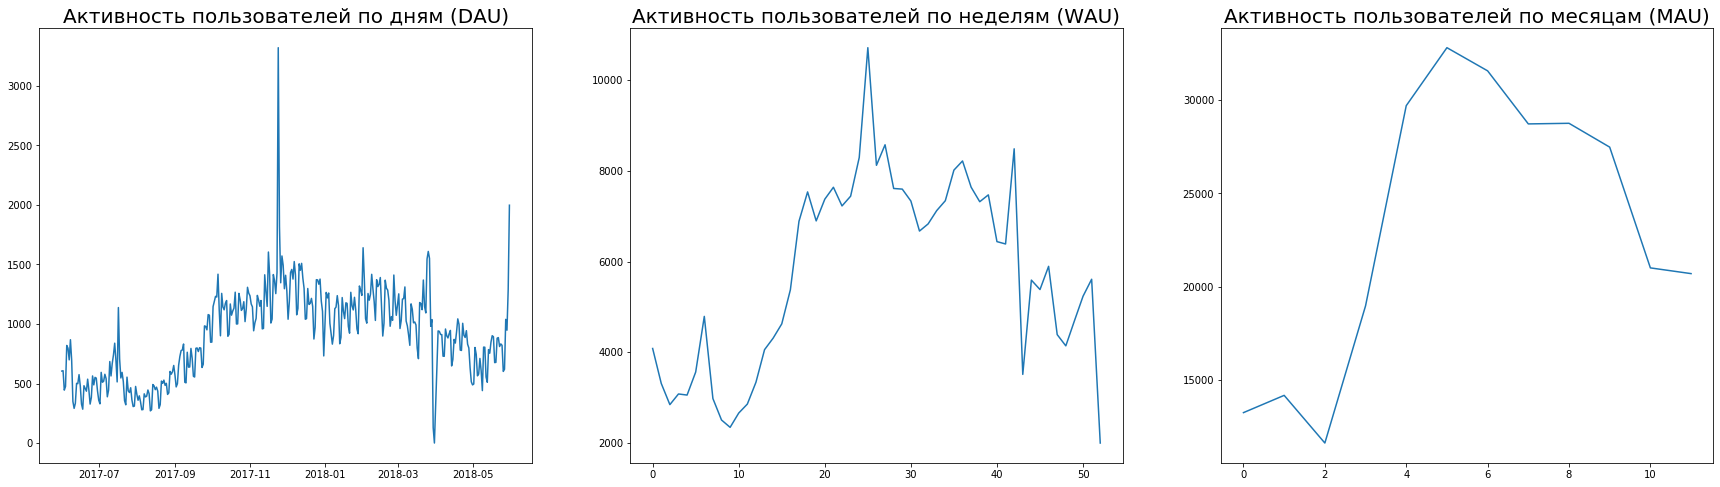

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(30, 8)

ax[0].plot(dau['date'], dau['uid'])
ax[0].set_title('Активность пользователей по дням (DAU)', size = 20)

ax[1].plot(wau['uid'])
ax[1].set_title('Активность пользователей по неделям (WAU)', size = 20)


ax[2].plot(mau['uid'])
ax[2].set_title('Активность пользователей по месяцам (MAU)', size = 20)

plt.show()

На всех трёх графиках виден пик пользовательской активности в конце 2017 - начале 2018 года, и затем постепенный спад.  
Динамика пользовательской активности может быть связана как с маркетинговыми факторами, так и с сезонными (летом пользователю любят гулять на воздухе, а зимой их тянет в кино). К сожалению, у нас есть данные только за один календарный год, так что мы не можем проверить влияние сезонных колебаний интереса пользователей.

Вычислим средние значения пользовательской активности за весь период.

In [23]:
dau_mean = dau['uid'].mean()
wau_mean = wau['uid'].mean()
mau_mean = mau['uid'].mean()

print('dau =', int(dau_mean))
print('wau =', int(wau_mean))
print('mau =', int(mau_mean))

dau = 907
wau = 5724
mau = 23228


In [24]:
sticky_mau = (dau_mean / mau_mean)*100
sticky_wau = (dau_mean / wau_mean)*100

print('sticky_wau =', sticky_wau.round(2))
print('sticky_mau =', sticky_mau.round(2))


sticky_wau = 15.86
sticky_mau = 3.91


Sticky factor для недели составляет примерно 16%, а для месяца - всего около 4%. Пользователи слишком мало возвращаются в сервис.

#### Количество посещений в день

Посмотрим, как меняется среднее количество посещений Яндекс Афиши пользователями в день.

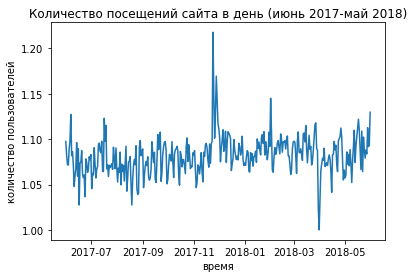

In [25]:
visits_per_day = visits.groupby('date').agg({'uid' : ['count','nunique']}).reset_index()
visits_per_day.columns = ['date', 'n_sessions', 'n_users']
visits_per_day['visits_per_day'] = visits_per_day['n_sessions'] / visits_per_day['n_users']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(visits_per_day['date'], visits_per_day['visits_per_day'])
ax.set_title('Количество посещений сайта в день (июнь 2017-май 2018)')
ax.set_xlabel('время')
ax.set_ylabel('количество пользователей')
plt.show()

При этом среднее количество заходов на сайт на одного пользователя практически не меняется, держится на уровне слегка больше единицы. Рассчитаем среднее количество посещений в день за весь период:

In [26]:
visits_per_day_mean = visits_per_day['visits_per_day'].mean()
print('Cреднее количество посещений в день за весь период:', visits_per_day_mean.round(2))

Cреднее количество посещений в день за весь период: 1.08


Интересно, что пик среднего количества заходов на сайт примерно совпадает с пиком количества активных пользователей в день (`dau`). Возможно, больше всего люди хотят отдыхать в новый год? А с чем тогда связан минимум активности?  
проверим, на какие даты приходится минимум и максимум `dau` и среднего количества заходов на сайт на одного пользователя.  

Минимальное количество посещений и уникальных пользователей:

In [27]:
dau_min = dau.loc[dau.loc[:, 'uid'] == dau['uid'].min()]
visits_per_day_min = visits_per_day.loc[visits_per_day.loc[:, 'visits_per_day'] == visits_per_day['visits_per_day'].min()]

print('Минимум активных пользователей приходится на: \n', dau_min, '\n')
print('Минимум среднего количества посещений приходится на \n', visits_per_day_min)

Минимум активных пользователей приходится на: 
            date  uid
303  2018-03-31    1 

Минимум среднего количества посещений приходится на 
            date  n_sessions  n_users  visits_per_day
303  2018-03-31           1        1             1.0


Одно посещение от одного пользователя на фоне средних значений в сотни пользователей - это очень мало. Нужно проверить, не было ли сбоя в этот день (это явно аномалия, она может объясняться, например, тем, что данные в этот день почему-то не записались).

Посмотрим на максимальные значения количества уникальных пользоватлей и среднего количества посещений в день:

In [28]:
dau_max = dau.loc[dau.loc[:, 'uid'] == dau['uid'].max()]
visits_per_day_max = visits_per_day.loc[visits_per_day.loc[:, 'visits_per_day'] == visits_per_day['visits_per_day'].max()]

print('Максимум активных пользователей приходится на \n', dau_max, '\n')
print('Максимум среднего количества посещений приходится на \n', visits_per_day_max)

Максимум активных пользователей приходится на 
            date   uid
176  2017-11-24  3319 

Максимум среднего количества посещений приходится на 
            date  n_sessions  n_users  visits_per_day
176  2017-11-24        4042     3319        1.217837


Пиковые дни действительно совпадают 24 ноября было больше всего уникальных пользователей и польше всего посещений сайта на каждого пользователя (в среднем). Было какое-то особенно интересное событие или маркетологи провели супер-успешную кампанию?

#### Продолжительность типичной пользовательской сессии 
Рассчитаем продолжительность каждой сессии и построим частотную гистограмму.

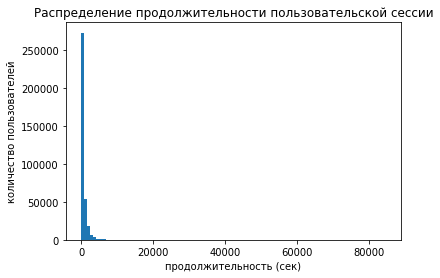

In [29]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(visits['session_duration_sec'], bins=100)
ax.set_title('Распределение продолжительности пользовательской сессии')
ax.set_xlabel('продолжительность (сек)')
ax.set_ylabel('количество пользователей')
plt.show()

Распределение отличается от нормального, так что для вычисления средней продолжительности пользовательской сессии используем моду.

In [30]:
print(visits['session_duration_sec'].mode()[0])

60


Продолжительность типичной пользовательской сессии - 60 секунд (1 минута). С одной стороны, это немного, а с другой - за это время можно сделать достаточно много.

#### Retention Rate

Рассчитаем коэффициент удержания.  
Находим первую сессию для каждого пользователя:

In [31]:
first_activity = visits.groupby('uid')['start_ts'].min()
display(first_activity.head())

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

Время первой пользовательской сессии добавляем в таблицу `visits` и округляем до месяца.

In [32]:
first_activity.name = 'first_activity'
visits = visits.merge(first_activity, on='uid')
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')
display(visits.head())

,device,end_ts,source_id,start_ts,uid,date,week,month,session_duration_sec,first_activity,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-20 17:20:00,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-19 16:53:00,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-09 20:05:00,2018-03-01
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-09 20:05:00,2018-03-01


Находим возраст когорты:    

In [33]:
visits['first_activity_month'] = pd.to_datetime(visits['first_activity_month'])


visits['cohort_age'] = ((visits['month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')).round().astype('int')

display(visits['cohort_age'].unique())

array([ 0,  2,  1,  7,  6,  8,  4,  9,  5, 11,  3, 10])

Группируем таблицу по когортам и по месяцам жизни когорт и считаем уникальных пользователей в каждом месяце и сохраняем в таблицу `cohorts`:  

In [34]:
cohorts = visits.groupby(['first_activity_month', 'cohort_age']).agg({'uid':'nunique'}).reset_index()

display(cohorts.head())

,first_activity_month,cohort_age,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Находим в каждой когорте исходное количество пользователей:

In [35]:
initial_users_count = cohorts[cohorts['cohort_age'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

display(initial_users_count.head())

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


Добавляем данные о количестве пользователей в таблицу `cohorts`

In [36]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')
display(cohorts.head())

,first_activity_month,cohort_age,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


Рассчитываем `Retention Rate` и на основе свобной таблицы по когортам создаём тепловую карту:

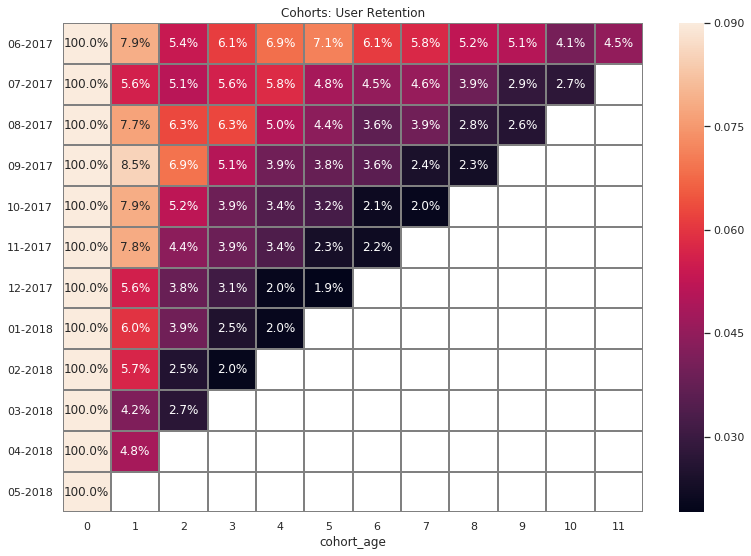

In [76]:
cohorts['retention'] = (cohorts['uid'] / cohorts['cohort_users'])

retention_pivot = cohorts.pivot_table(
    index='first_activity_month',
    columns='cohort_age',
    values='retention',
    aggfunc='sum'
)
retention_pivot.index = retention_pivot.index.strftime("%m-%Y")

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, vmax=0.09, fmt='.1%', linewidths=1, linecolor='gray')
plt.show()

Во второй месяц жизни когорты Retention Rate колеблется от 4 до 8.5%, при это в когортах первой половины периода наблюдений он несколько выше (в большинстве когорт около 8%), а во второй половине - несколько снижается (4-6%).  
    Аналогичная картина наблюдается в следующие месяцы: у каждой следующей когорты снижение активности в последующие месяцы происходит немного быстрее.
    
Рассчитаем среднее значение Retention Rate для второго месяца жизни когорты.

In [38]:
retention_2_mean = retention_pivot[1].mean()

print(retention_2_mean)

0.06516659710392834


Cреднее значение Retention Rate для второго месяца жизни когорты составляет около 6,5%.

#### Выводы по продуктовым метрикам

1. Пик пользовательской активности приходится на конец 2017 - начало 2018 года, после этого идёт постепенный спад. Динамика пользовательской активности может быть связана как с маркетинговыми факторами, так и с сезонными.
2. Sticky factor для недели составляет примерно 16%, а для месяца - около 4%. Пользователи слишком мало возвращаются в сервис.
3. Количество заходов на сайт на одного пользователя практически не меняется на протяжении года, держится на уровне слегка больше единицы (среднее количество посещений 1.08). 
4. Больше всего посещений и уникальных пользователей было 24 ноября 2017 года. Стоит обратить внимание, что именно привело к такому бурному росту посещаемости.
5. 31 марта 2018 года в данных наблюдается явная аномалия: записано всего одно посещение от единственного пользователя. Необходимо отправить баг репорт.
6. Продолжительность типичной пользовательской сессии - 60 секунд (1 минута).
7. Cреднее значение Retention Rate для второго месяца жизни когорты составляет около 6,5%, при этом в когортах 2017 года Retention Rate несколько выше и снижается со временем несколько медленнее, чем у когорт 2018.  

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 2:
   
Отлично, средний Retention Rate ывычилсен верно. 👍👍👍 
</div>

<div class="alert alert-block alert-success">
Комментарий ревьюера v. 1:
    
Да, наблюдается снижение Retention Rate с течением времени.

Молодец, что подвела итог анализа.
</div>

### Метрики электронной коммерции

#### Среднее время от первого посещения сайта до совершения покупки

Добавим в таблицу `visits` данные о покупках.

Добавляем в таблицу `orders` данные столбца `first_activity` по `uid`

In [39]:
orders = orders.merge(first_activity, on='uid')

display(orders.head())

,buy_ts,revenue,uid,first_activity
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


Рассчитаем промежуток времени от первого посещения до покупки в столбце `time_to_buy`:

In [40]:
orders['time_to_buy'] = (orders['buy_ts'] - orders['first_activity'])


Построим частотную гистограмму, чтобы определить тип распределения. Единицей измерения выберем минуты.

### **Исправление 7 (обосновала выбор метода)**

<div class="alert alert-info">
Добавила гистограмму в масштабе дней:
</div>

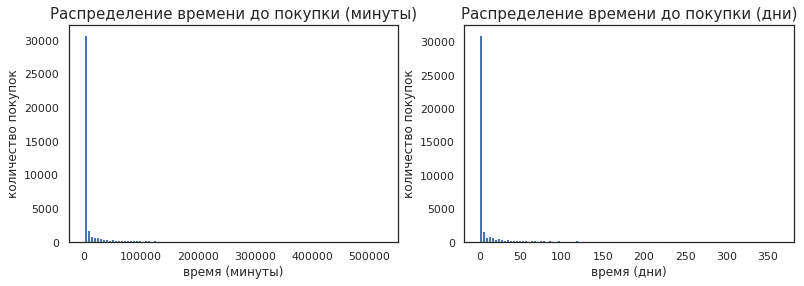

In [41]:

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(13, 4)

ax[0].hist(orders['time_to_buy'].astype('timedelta64[m]'), bins=100)
ax[0].set_title('Распределение времени до покупки (минуты)', size = 15)
ax[0].set_xlabel('время (минуты)')
ax[0].set_ylabel('количество покупок')

ax[1].hist(orders['time_to_buy'].astype('timedelta64[D]'), bins=100)
ax[1].set_title('Распределение времени до покупки (дни)', size = 15)
ax[1].set_xlabel('время (дни)')
ax[1].set_ylabel('количество покупок')

plt.show()

На гистограмме видно пик в районе близких к нулю значений. Найдём моду для столбца `time_to_buy`, единицей измерения выберем секунды.

Распределение отличается от нормального, поэтому среднее значение в качестве средней меры не подходит.  
    
При этом достаточно много значений находится сильно правее по шкале (даже в масштабе дней), а не сходит на нет, поэтому может быть оправдано использовать моду или медиану - в зависимости от целей. В данном случае, скорее всего, на форму распределения оказывают влияние разные факторы: пик на маленьких значениях отражает тех пользователей, которые совершали "быструю покупку", а растянутый "хвост" - тех, кого первое знакомство с сайтом не убедило совершить покупку, но они вернулись позже за чем-то другим. В нашем случае логично выбрать моду, так как нас интересуют быстрые покупки, а не отложенные.

In [42]:
print(orders['time_to_buy'].astype('timedelta64[s]').mode()[0])

60.0


Среднее время покупки - 60 секунд.  
Посмотрим на гистограммы в большем масштабе:

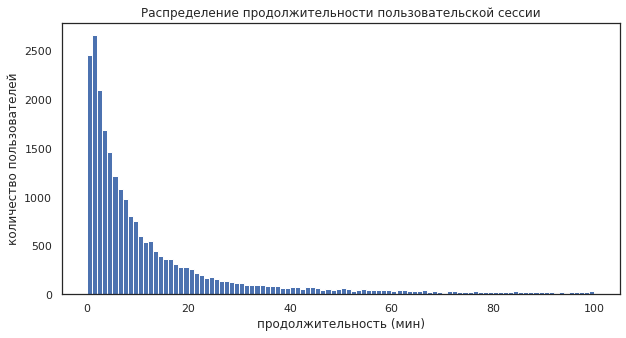

In [43]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.hist(orders['time_to_buy'].astype('timedelta64[m]'), bins=100, range=(0, 100))
ax.set_title('Распределение продолжительности пользовательской сессии')
ax.set_xlabel('продолжительность (мин)')
ax.set_ylabel('количество пользователей')
plt.show()

Чем меньше время, тем больше вероятность покупки. Пик покупок действительно находится около нуля, вероятность совершить покупку со временем убывает экспоненциально, а на времени около получаса выходит практически на горизонтальную линию. Вероятно, совершая покупку, пользователи уже хорошо знают, чего хотят.

#### Среднее количество покупок за 6 месяцев

Для того, чтобы вычислить среднее количество покупок за 6 месяцев, сделаем срез по столбцу `time_to_buy` и с группируем данные по пользователям.  
Выделим все покупки, которые произошли в первые 6 месяцев активности пользователя (`time_to_buy` < 6 месяцев) и только тех пользователей, для которых есть данные больше, чем за полгода наблюдения.

In [44]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 5 columns):
buy_ts            50415 non-null datetime64[ns]
revenue           50415 non-null float64
uid               50415 non-null object
first_activity    50415 non-null datetime64[ns]
time_to_buy       50415 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(1), timedelta64[ns](1)
memory usage: 2.3+ MB


In [45]:
fin_day = orders['buy_ts'].max() - np.timedelta64(5, 'M')

purchases_per_6m = orders.loc[(
    orders.loc[:, 'time_to_buy'] < np.timedelta64(6, 'M')) & (
    orders.loc[:, 'first_activity'] < fin_day)
].groupby('uid').agg({'buy_ts' : 'count'})



Построим гистограмму, для того, чтобы выбрать адевактный метод оценки среднего количества покупок.

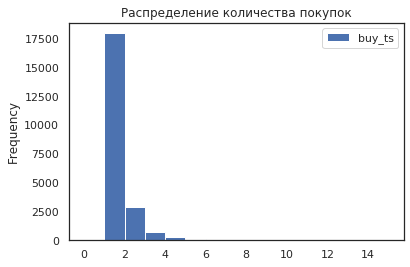

In [46]:
purchases_per_6m.plot.hist(bins=15, range=(0, 15), title='Распределение количества покупок')
plt.show()

Распределение отличается от нормального, используем моду.

In [47]:
print('Среднее количество покупок на одного пользователя за полгода:', purchases_per_6m.mode())

Среднее количество покупок на одного пользователя за полгода:    buy_ts
0       1


Большинство пользователей делают всего одну покупку за полгода, примерно вдвое меньше пользователей делает 2 покупки.

#### Средний чек покупателей

Сгруппируем покупки по покупателям и по времени покупки, сумму заказа просуммируем.

In [48]:
bills = orders.groupby(['uid', 'buy_ts']).agg({'revenue' : 'sum'}).reset_index()
print(bills.head())



                uid              buy_ts  revenue
0   313578113262317 2018-01-03 21:51:00     0.55
1  1575281904278712 2017-06-03 10:13:00     1.22
2  1575281904278712 2017-06-03 17:39:00     1.83
3  2429014661409475 2017-10-11 18:33:00    73.33
4  2464366381792757 2018-01-28 15:54:00     2.44


Построим частотную гистограмму

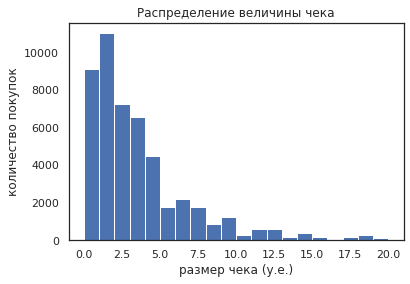

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(bills['revenue'], bins=20, range=(0, 20))
ax.set_title('Распределение величины чека')
ax.set_xlabel('размер чека (у.е.)')
ax.set_ylabel('количество покупок')
plt.show()

Распределение отличается от нормального, поэтому для расчёта среднего чека за всё время используем медиану.

In [50]:
print('Средний чек за весь период составляет: {} у.е.'.format(bills['revenue'].median()))

Средний чек за весь период составляет: 2.5 у.е.


Посмотрим на динамику среднего чека. Создадим столбец `week` и сгруппируем данные по нему.

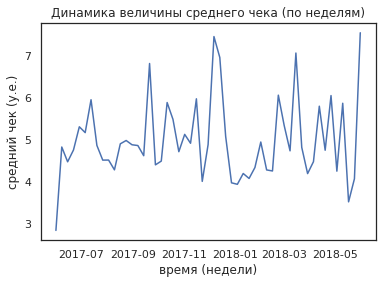

In [51]:
bills['week'] = bills['buy_ts'].astype('datetime64[W]')
bills_mean_by_week = bills.groupby('week')['revenue'].mean()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(bills_mean_by_week)
ax.set_title('Динамика величины среднего чека (по неделям)')
ax.set_xlabel('время (недели)')
ax.set_ylabel('средний чек (у.е.)')
plt.show()

Величина среднего чека колеблется от недели к неделе. Вероятно, периодически кто-то совершает большие покупки (возможно, какие-то корпоративные покупки?), и это влияет на величину среднего чека в неделю.  
Отсортируем таблицу `bills` по убыванию столбца `revenue` и выведем первые 5 строк:

In [52]:
display(bills.sort_values(by='revenue', ascending=False).head())

,uid,buy_ts,revenue,week
15497,5539673724080479777,2017-12-10 20:17:00,2633.28,2017-12-07
30958,11149926373378902217,2018-02-23 08:54:00,1236.28,2018-02-22
30959,11149926373378902217,2018-02-24 09:25:00,1221.37,2018-02-22
15495,5539673724080479777,2017-12-10 13:04:00,1195.64,2017-12-07
30953,11149926373378902217,2017-12-17 18:06:00,1109.10,2017-12-14


Есть один огромный счёт на 218т. у.е., и несколько просто очень больших (при том, что медианный чек составляет 5.5 у.е.). При этом три покупки из пяти сделал один покупатель.  
Посчитаем, сколько всего было сделано покупок на сумму больше 1000 у.е. и сгруппируем их по покупателям.

In [53]:
huge_purchases = bills.query('revenue > 1000').groupby('uid').agg({'revenue' : ['nunique', 'sum']}).reset_index()
huge_purchases.columns = ['uid', 'n_purchases', 'total_revenue']
display(huge_purchases.sort_values(by='total_revenue', ascending=False).head())

,uid,n_purchases,total_revenue
1,11149926373378902217,5,5720.30
0,5539673724080479777,2,3828.92


77 покупок от одного клиента на общую сумму почти что в миллион у.е. Один человек точно не мог столько культурно развлекаться. И вряд ли это аномалия в данных: таких клиентов много, то есть это именно особая категория клиентов.  
Стоит запросить дополнительные данные и выяснить, что это за клиенты, а маркетологам - обращать на эту категорию особое внимание.

#### LTV пожизненная ценность клиента



Для расчёта LTV напишем функцию `cohort_ltv`, которая будет принимать таблицу с покупками пользователей и названиями столбцов и возвращать сводную таблицу с накопительными значениями LTV.

In [54]:
def cohort_ltv(data, uid, order_date, cohort_period, margin_rate, revenue):
    """Функция для расчёта LTV.
    Выводит тепловую карту метрики LTV по когортам по заданным промежуткам времени.
    Принимает аргументы:
        data - название таблицы;
        uid - название столбца с идентификаторами пользователя (для подсчёта количества исходных пользователей в когорте);
        order_date - название столбца с данными о датах покупки;
        margin_rate - маржинальность;
        cohort_period - период для выделения когорт;
        revenue - прибыль"""
        
    """Выделяем периоды для формирования когорт"""
    data[order_date] = data[order_date].astype('datetime64[{}]'.format(cohort_period)) 
    
    """Находим для каждого пользователя время первого заказа и добавляем его в таблицу"""
    first_order = data.groupby(uid)[order_date].min().reset_index()
    first_order.columns = [uid, 'first_order']
    data = data.merge(first_order, on=uid)
    
    """Рассчитываем возраст когорт"""
    data['age'] = ((data[order_date] - data['first_order']
                  ) / np.timedelta64(1, cohort_period)).round().astype('int')
    
    """Рассчитываем размер когорт"""
    cohort_sizes = first_order.groupby('first_order').agg({uid : 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order', 'n_buyers']  
    
    """Формируем когорты"""
    cohorts = data.groupby(['first_order', 'age']).agg({revenue : 'sum'}).reset_index()    
    
    """Добавляем в таблицу с когортами размер когорты"""
    cohorts = cohorts.merge(cohort_sizes, on='first_order')
            
    """Считаем валовую прибыль"""
    cohorts['gp'] = cohorts[revenue]*margin_rate

    """Рассчитываем LTV"""
    cohorts['ltv'] = cohorts['gp'] / cohorts['n_buyers']
    
    """Создаём сводную таблицу output,
    - по строкам: когорты,
    - по столбцам: возраст когорт,
    - значния: валовая прибыль,
    - агг. функция: среднее значение"""
    
    output = cohorts.pivot_table(
        index='first_order', columns='age', values='ltv', aggfunc='mean'
    ).round(2)
    
    """Рассчитываем и выводим кумулятивные значения LTV"""
    cum_output = output.cumsum(axis=1)
    cum_output.index = cum_output.index.strftime("%m-%Y")
        
    return cum_output


Применяем функцию:

In [55]:
cohort_ltv_output = cohort_ltv(orders, 'uid', 'buy_ts', 'M', 1, 'revenue')
display(cohort_ltv_output.fillna(''))

age,0,1,2,3,4,5,6,7,8,9,10,11
06-2017,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
07-2017,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
08-2017,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
09-2017,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
10-2017,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
11-2017,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
12-2017,4.74,5,5.93,7,7.31,7.65,,,,,,
01-2018,4.14,4.43,4.73,4.87,4.93,,,,,,,
02-2018,4.16,4.44,4.52,4.59,,,,,,,,
03-2018,4.84,5.14,5.46,,,,,,,,,


Строим тепловую карту:

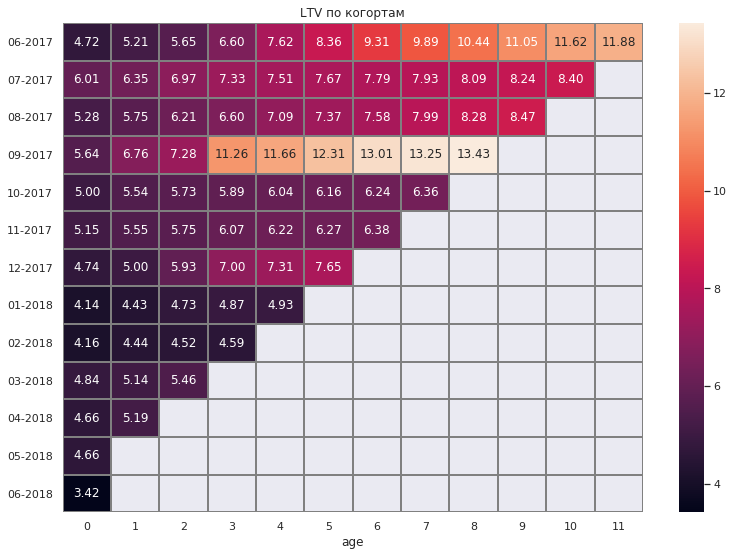

In [56]:
sns.set()
plt.figure(figsize=(13, 9))
plt.title('LTV по когортам')
ax = sns.heatmap(cohort_ltv_output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Выделяются когорты июня 2017 и особенно сентября 2018. Когорты 2018 года выглядят менее перспективными, чем когорты 2017.

Рассчитаем средний LTV по когортам за 6 месяцев:

In [57]:
m6_cum_ltv = cohort_ltv_output[5].mean()
print('Средний LTV по когортам за 6 месяцев: {:.0f} у.е.'.format(m6_cum_ltv))

Средний LTV по когортам за 6 месяцев: 8 у.е.


#### Выводы по метрикам электронной коммерции

1. Большая часть покупок совершается меньше, чем за минуту, вероятность совершить покупку со временем убывает экспоненциально, а на времени около получаса выходит практически на горизонтальную линию. Вероятно, совершая покупку, пользователи уже хорошо знают, чего хотят.  
2. Большинство пользователей делают всего одну покупку за полгода.  
3. Величина чека очень неравномерна. Средний чек за весь период составляет 5.5 у.е., но есть чеки на порядки больше. Есть особая группа клиентов, которые делают покупки чаще и больше других. Вероятно, стоит уделить ей особое внимание.  
4. Средний LTV за полгода составляет 8 у.е.. Наиболее перспективные когорты - сентябрь 2017 и июнь 2017. Когорты 2017 года более прибыльные, чем когорты 2018.  

### Маркетинговые метрики

#### Расходы на маркетинг

Выведем первые 5 строк таблицы `costs`.

In [58]:
display(costs.head())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Подсчитаем общую сумму расходов за весь период:

In [59]:
total_costs = costs['costs'].sum()
print('Общая сумма расходов на маркетинг за весь период: {} у.е.'.format(total_costs))

Общая сумма расходов на маркетинг за весь период: 329131.62 у.е.


Подсчитаем сумму трат по источникам:

In [60]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()
display(costs_by_source)

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


За исследуемый период проведено 7 кампаний, у кампаний 9 и 10 совсем небольшой бюджет, а кампания 3 - весьма дорогая.  

Построим тепловую карту для расходов по месяцам для каждого источника. Для этого выделим в отдельную колонку месяц трат и создадим сводную таблицу с тратами по месяцам для каждой кампании.

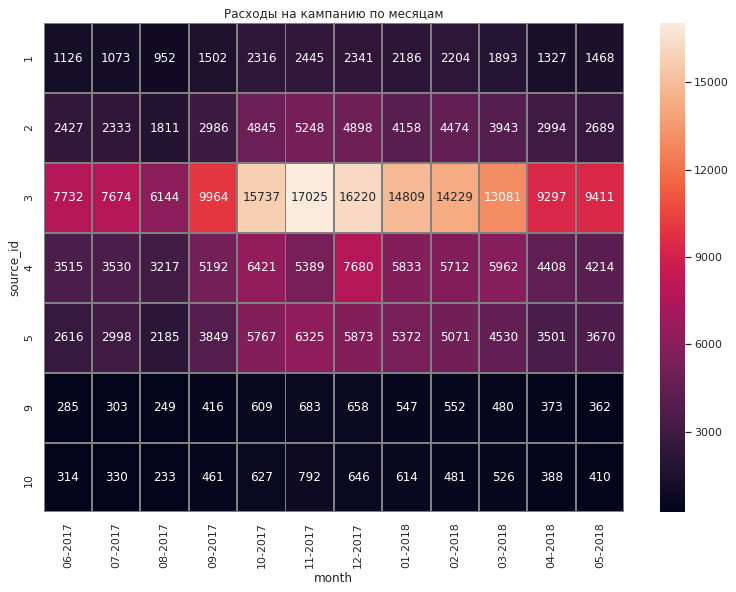

In [61]:
costs['month'] = costs['dt'].astype('datetime64[M]')
campaign_costs = costs.pivot_table(
    index='source_id', columns='month', values='costs', aggfunc='sum'
)

sns.set()
plt.figure(figsize=(13, 9))
plt.title('Расходы на кампанию по месяцам')
ax = sns.heatmap(campaign_costs, annot=True, fmt='.0f', linewidths=1, linecolor='gray')
ax.set_xticklabels(campaign_costs.columns.strftime('%m-%Y'))
plt.show()

Интересно: зимой расходы на маркетинг по всем кампаниям были больше, чем летом. И активность пользователей зимой была больше. А вот средний чек зимой не стал сильно больше.  

Построим график суммарных расходов по источникам:

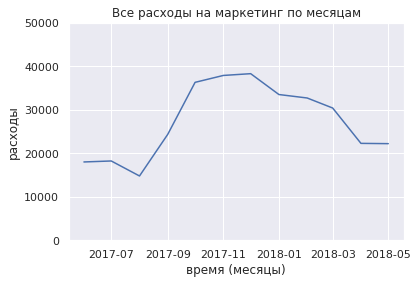

In [62]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title('Все расходы на маркетинг по месяцам')
ax.plot(campaign_costs.sum(axis=0))
ax.set(xlabel ='время (месяцы)', ylabel='расходы', ylim=[0, 50000])
ax.grid(True)
plt.show()

За осень 2017 года расходы на маркетинг выросли больше, чем в два раза, а за весну снова снизились.



#### Стоимость привлечения клиента (CAC)

Рассчитаем САС для всего проекта:

In [63]:
n_users = visits['uid'].nunique()
cac = total_costs / n_users

print('Стоимость привлечения клиента (САС) составляет {:.2f} у.е.'.format(cac))

Стоимость привлечения клиента (САС) составляет 1.44 у.е.


Рассчитаем САС по кампаниям. Чтобы посчитать количество клиентов, привлечённых каждой из кампаний, определим для каждого клиента первый источник перехода.

In [64]:
main_source = visits.sort_values(
    by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'}).reset_index()
main_source.columns = ['uid', 'main_source']

display(main_source.head())

,uid,main_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Посчитаем количество пользователей для каждого источника трафика:

In [65]:
n_users_by_source = main_source.groupby('main_source')['uid'].count().reset_index()
n_users_by_source = n_users_by_source.rename(columns={'uid' : 'n_users'})
display(n_users_by_source)

,main_source,n_users
0,1,9469
1,2,17616
2,3,66116
3,4,72346
4,5,49237
5,6,2
6,7,32
7,9,6448
8,10,6903


Кампаниями 6 и 7 привлечено совсем мало клиентов. Вероятно, это какие-то уже завершившиеся кампании.  
Удалим строки источниками трафика 6 и 7 из таблицы `n_users_by_source`.

In [66]:
n_users_by_source = n_users_by_source.drop(n_users_by_source.loc[n_users_by_source.loc[:, 'main_source'] == 7].index)
n_users_by_source = n_users_by_source.drop(n_users_by_source.loc[n_users_by_source.loc[:, 'main_source'] == 6].index)

print(n_users_by_source['main_source'].unique())

[ 1  2  3  4  5  9 10]


Добавим информацию о главном источнике трафика для каждого клиента в таблицу `visits`.

In [67]:
visits = visits.merge(main_source, on='uid')
display(visits.head())

,device,end_ts,source_id,start_ts,uid,date,week,month,session_duration_sec,first_activity,first_activity_month,cohort_age,main_source
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,1080,2017-12-20 17:20:00,2017-12-01,0,4
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,1680,2018-02-19 16:53:00,2018-02-01,0,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0,5
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,1440,2018-03-09 20:05:00,2018-03-01,2,4
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09,2018-03-08,2018-03-01,1680,2018-03-09 20:05:00,2018-03-01,0,4



Объединим таблицы `n_users_by_source` и `costs_by_source` и посчитаем САС для каждой кампании:

In [68]:
cac_by_source = costs_by_source.merge(n_users_by_source, left_on = 'source_id', right_on = 'main_source')
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['n_users']
display(cac_by_source)

,source_id,costs,main_source,n_users,cac
0,1,20833.27,1,9469,2.200155
1,2,42806.04,2,17616,2.429952
2,3,141321.63,3,66116,2.137480
3,4,61073.60,4,72346,0.844188
4,5,51757.10,5,49237,1.051183
5,9,5517.49,9,6448,0.855690
6,10,5822.49,10,6903,0.843472


Построим график CAC по кампаниям.

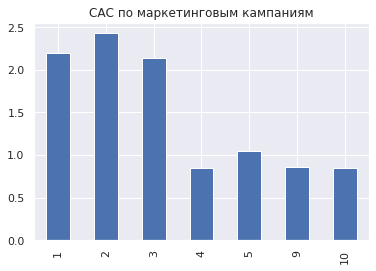

In [69]:
fig = plt.figure()
ax = cac_by_source['cac'].plot(kind='bar')
ax.set_xticklabels(cac_by_source['main_source'])
ax.set_title('CAC по маркетинговым кампаниям')
plt.show()

Самые дорогие (в пересчёте на одного клиента) - кампании 2 и 3, а в кампаниях 9 и 10, несмотря на то, что сами по себе они довольно бюджетные, привлечение клиента стоит гораздо меньше.  

#### ROMI возврат на инвестиции в маркетинг

Рассчитаем расходы на привлечение клиентов для каждой когорты (по источникам):

In [70]:
costs['dt'] = costs['dt'].astype('datetime64[M]')   
costs_by_cohorts = costs.groupby(['source_id', 'dt'])['costs'].sum().reset_index()
costs_by_cohorts.columns = ['source_id', 'month', 'costs']
display(costs_by_cohorts.head())

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Добавим в таблицу `orders` столбец `main_sourse` и удалим строки с главным источником трафика 6 и 7. 

In [71]:
orders = orders.merge(main_source, on='uid')
orders = orders.drop(orders.loc[orders.loc[:, 'main_source'] == 6].index)
orders = orders.drop(orders.loc[orders.loc[:, 'main_source'] == 7].index)


display(orders.head())
print(orders['main_source'].unique())


,buy_ts,revenue,uid,first_activity,time_to_buy,main_source
0,2017-06-01,17.00,10329302124590727494,2017-06-01 00:09:00,00:01:00,1
1,2017-06-01,0.55,11627257723692907447,2017-06-01 00:14:00,00:11:00,2
2,2017-06-01,0.37,17903680561304213844,2017-06-01 00:25:00,00:02:00,2
3,2017-06-01,0.55,16109239769442553005,2017-06-01 00:14:00,00:15:00,2
4,2017-06-01,0.37,14200605875248379450,2017-06-01 07:31:00,00:27:00,3


[ 1  2  3  5  4  9 10]


На основе функции `cohort_ltv` сделаем функцию `cohort_romi`.

In [72]:
def cohort_romi(data1, uid, order_date, cohort_period, margin_rate, revenue, data2, costs_period, costs):
    """Функция для расчёта ROMI.
    Выводит тепловую карту метрики ROMI по когортам по заданным промежуткам времени.
    Принимает аргументы:
        data - название таблицы с данными о пользовательской активности и покупках;
        uid - название столбца с идентификаторами пользователя (для подсчёта количества исходных пользователей в когорте);
        order_date - название столбца с данными об активности пользователя и покупках (для нахождения первой активности);
        margin_rate - маржинальность;
        cohort_period - период для выделения когорт;
        revenue - прибыль;
        data2 - название таблицы с данными о расходах по периодам;
        costs_period - название столбца с периодами из data2;
        costs - название столбца с расходами изdata2     """
        
    """Рассчитываем LTV"""
    """Выделяем периоды для формирования когорт"""
    data1[order_date] = data1[order_date].astype('datetime64[{}]'.format(cohort_period)) 
    
    """Находим для каждого пользователя время первого заказа и добавляем его в таблицу"""
    first_order = data1.groupby(uid)[order_date].min().reset_index()
    first_order.columns = [uid, 'first_order']
    data1 = data1.merge(first_order, on=uid)
    
    """Рассчитываем возраст когорт"""
    data1['age'] = ((data1[order_date] - data1['first_order']
                  ) / np.timedelta64(1, cohort_period)).round().astype('int')
    
    """Рассчитываем размер когорт"""
    cohort_sizes = first_order.groupby('first_order').agg({uid : 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order', 'n_buyers']  
    
    """Формируем когорты"""
    cohorts = data1.groupby(['first_order', 'age']).agg({revenue : 'sum'}).reset_index()    
    
    """Добавляем в таблицу с когортами размер когорты"""
    cohorts = cohorts.merge(cohort_sizes, on='first_order')
            
    """Считаем валовую прибыль"""
    cohorts['gp'] = cohorts[revenue]*margin_rate

    """Рассчитываем LTV"""
    cohorts['ltv'] = cohorts['gp'] / cohorts['n_buyers']
    
    """Рассчитываем САС"""
    """Добавляем в таблицу cohorts данные о расходах на маркетинг"""
    data2[costs_period] = data2[costs_period].astype('datetime64[{}]'.format(cohort_period))    
    
    cohorts = cohorts.merge(data2, left_on='first_order', right_on=costs_period)
    
    """Рассчитаем САС"""
    cohorts['cac'] = cohorts[costs] / cohorts['n_buyers']
    
    """Рассчитаем ROMI"""
    cohorts['romi'] = cohorts['ltv'] / cohorts['cac']
    
    """Создаём сводную таблицу output,
    - по строкам: когорты,
    - по столбцам: возраст когорт,
    - значения: ROMI,
    - агг. функция: среднее значение"""
    
    output = cohorts.pivot_table(
        index=costs_period, columns='age', values='romi', aggfunc='mean'
    )
    
    """Рассчитываем и выводим кумулятивные значения ROMI"""
    cum_output = output.cumsum(axis=1).round(2)
    cum_output.index = cum_output.index.strftime("%m-%Y")

    return cum_output 


Сгруппием таблицу `orders` по столбцу `main_sourse` и рассчитаем ROMI с помощью функции `cohort_romi`. Внутри группировки сделаем срез таблицы `costs_by_cohorts` по когорте.

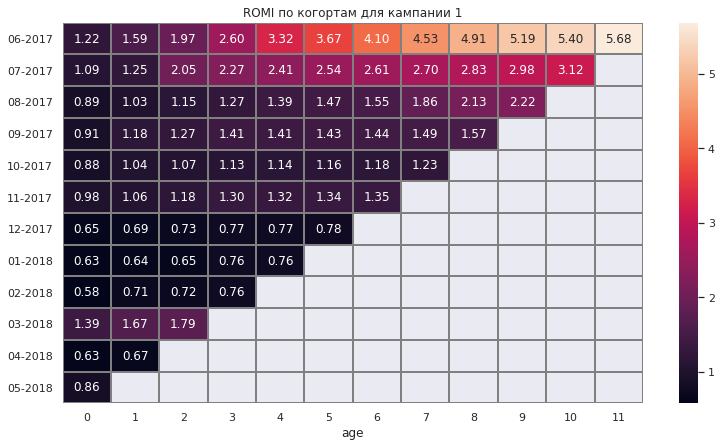

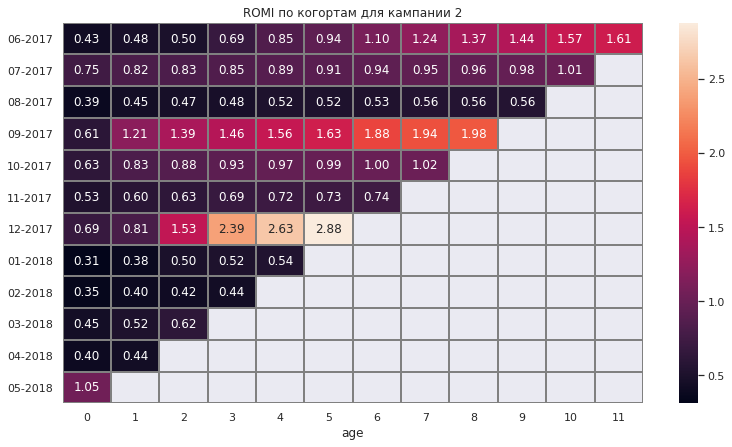

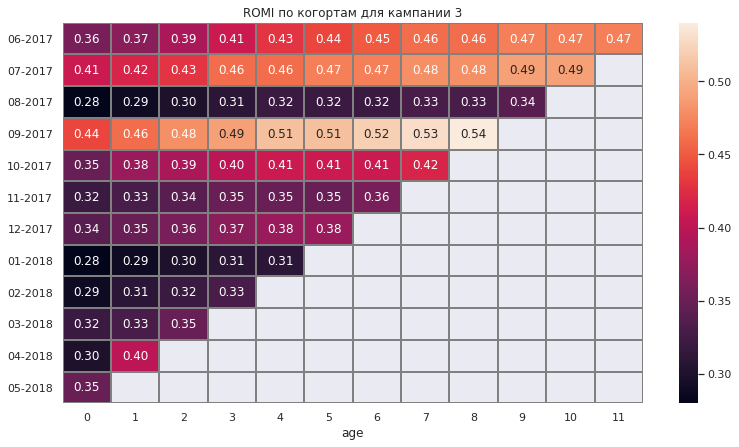

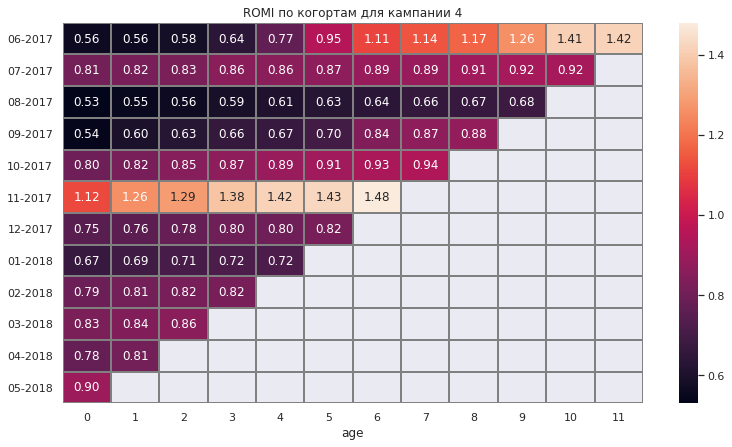

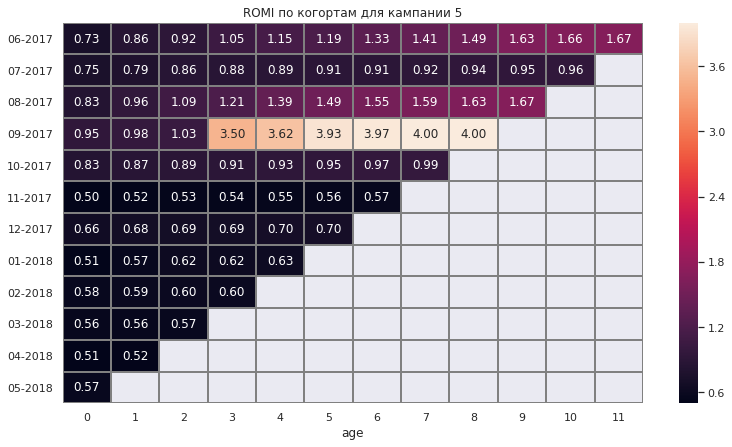

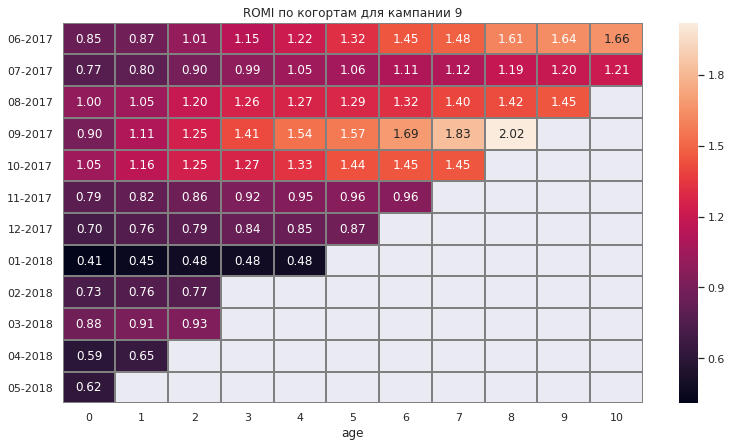

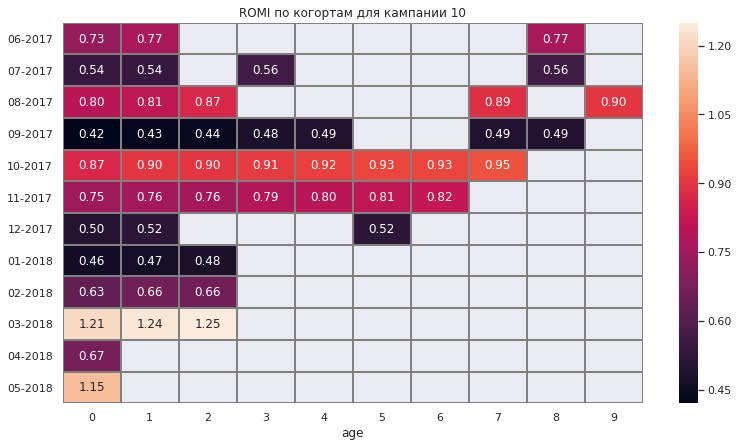

In [73]:
for name, data_grouped in orders.groupby('main_source'):
    """Делаем срез таблицы `costs_by_cohorts` по когорте, выделяем нужную когорту"""
    costs_by_cohort_grouped = costs_by_cohorts.loc[costs_by_cohorts.loc[:, 'source_id'] == name]    
    
    """Рассчитываем ROMI при помощи функции"""
    romi = cohort_romi(data_grouped, 'uid', 'buy_ts', 'M', 1, 'revenue', costs_by_cohort_grouped, 'month', 'costs')
    
    """Строим тепловую карту"""
    sns.set()
    plt.figure(figsize=(13, 7))
    plt.title('ROMI по когортам для кампании {}'.format(name))
    ax = sns.heatmap(romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.show()

**Кампания 1**  
До декабря 2017 маркетинговые инвестиции окупались на второй месяц жизни когорты, а с декабря 2017 окупаемость сильно снизилась. Всего за наблюдаемый период кампания окупилась в семи когортах.  
    Наиболее перспективные когорты: июнь 2017, июль 2017, март 2018.


**Кампания 2**  
    Окупаемость кампании очень сильно меняется в зависимости от когорты: только в одной когорте кампания окупилась на второй месяц, при этом в 5 из 7 когорт не окупилась за полгода. Всего за наблюдаемый период кампания окупилась в шести когортах.  
    Наиболее перспективные когорты: сентябрь 2017, декабрь 2017, май 2018.  
    Наименее перспективная когорта: август 2017.  

**Кампания 3**  
    Не окупилась ни в одной из когорт. 

**Кампания 4**  
    За исследуемый период кампания окупилась только в двух когортах, рост прибыли очень медленный.
    Наиболее перспективные когорты: июнь 2017, ноябрь 2017.
    
**Кампания 5**  
    За исследуемый период кампания окупилась в трёх когортах. В когортах 2018 года рост прирост LTV очень слабый.  
    Наиболее перспективные когорты: июнь 2017, август 2017, сентябрь 2017

**Кампания 9**  
    За исследуемый период кампания окупилась в пяти когортах и близка к границе самоокупаемости ещё в двух. В когортах до ноября 2017 кампания окупалась за 2-3 месяца, в отдельных когортах - уже в первый месяц. В кампаниях 2018 года рост гораздо медленнее, в трёх когортах из пяти пока нет оснований ожидать, что кампания окупится.  
    Наиболее перспективные когорты: июнь 2017, август 2017, сентябрь 2017, октябрь 2017.  
    Наименее перспективная когорты: январь 2018, апрель 2018, май 2018.

**Кампания 10**  
За исследуемый период кампания окупил в двух когортах, причём в самых молодых. Покупатели возвращаются очень неравномерно, возможно это связано с активностью ведения кампании.  
    Наиболее перспективные когорты: март 2018, май 2018.  
    Наименее перспективная когорты: сентябрь 2017, декабрь 2017, январь 2018.


**Вывод**  
***Эффективность маркетинговых кампаний***  
Наиболее успешными маркетинговыми кампаниями оказались кампании 1, 2 и 9.  При этом в когортах 2017 года окупаемость наступает намного раньше, чем в когортах 2018 года. Возможно, это связано с большим объёмом маркетинговых инвестиций осенью 2017 года.  
Кампания 3 не окупается ни в одной из когорт в исследуемом периоде.  
Кампания неравномерный эффект. Только кампания 10 хорошол сработала в молодых когортах 2018 года.

***Перспективность когорт***  
Наиболее перспективные когорты: июнь-октябрь 2017.
Наименее перспективные когорты: январь, февраль, апрель 2018.

***Перспективность кампаний относительно когорт***  
В когорте `июнь 2017` были эффективны кампании 1, 2, 4, 5, 9.    
В когорте `июль 2017` наиболее эффективными были кампании 1, 2, 9.  
В когорте `август 2017` наиболее эффективными были кампании 1, 5, 9.  
В когорте `сентябрь 2017` наиболее эффективными были кампании 1, 2, 5, 9.  
В когорте `октябрь 2017` наиболее эффективными были кампании 2, 10.  
В когорте `ноябрь 2017` наиболее эффективной была кампания 4.  
В когорте `декабрь 2017` наиболее эффективной была кампания 2.  
В когорте `январь 2018` ближе всего к самоокупаемости подошли кампании 1 и 4.  
В когорте `февраль 2018` ближе всего к самоокупаемости подошла кампания 4.  
В когорте `март 2018` наиболее эффективными были кампании 1, 10.  
В когорте `апрель 2018` ближе всего к самоокупаемости подошла кампания 4.   
В когорте `май 2018` наиболее эффективными были кампании 2, 10.  

#### Выводы по маркетинговым метрикам

    1. Общая сумма расходов на маркетинг за весь период: 329131.62 у.е.
    2. За исследуемый период проведено 7 кампаний, у кампаний 9 и 10 небольшой бюджет, а у кампании 3 сильно больше других. 
    3. Зимой расходы на маркетинг по всем кампаниям были больше, чем летом. Возможно, именно с этим связана динамика активности пользователей.
    4. САС: Привлечение клиентов дороже всего обходится в кампанииях 2 и 3, и дешевле всего в кампаниях 9 и 10.
    5. ROMI: Наиболее успешными маркетинговыми кампаниями оказались кампании 1, 2 и 9, а наименее успешной - кампания 3. 

## Выводы и рекомендации

### Краткий обзор проведённой работы

Данные подготовлены к работе. Изменён тип данных столбцов в тех случаях, где он не соответствовал цели. 

Рассчитаны и проанализированы продуктовые метрики:  
    - DAU, WAU и MAU;  
    - количество посещений в день;   
    - продолжительность типичной пользовательской сессии;  
    - Retention Rate  

Рассчитаны и проанализированы метрики электронной коммерции:  
    - среднее время с первого посещения сайта до покупки;  
    - среднее количество покупок на одного покупателя за 6 месяцев;  
    - средний чек;  
    - LTV по когортам.  
    
Рассчитаны и проанализированы маркетинговые метрики:  
    - расходы на маркетинг (общие и по кампаниям);  
    - САС по кампаниям;  
    - ROMI по когортам для каждой кампании.  
    
Сформулированы выводы и рекомендации.

### Выводы
#### **Выводы по продуктовым метрикам**

    1. Пик пользовательской активности приходится на конец 2017 - начало 2018 года, после этого идёт постепенный спад. Динамика пользовательской активности может быть связана как с маркетинговыми факторами, так и с сезонными.
    2. Sticky factor для недели составляет примерно 16%, а для месяца - около 4%. Пользователи слишком мало возвращаются в сервис.
    3. Количество заходов на сайт на одного пользователя практически не меняется на протяжении года, держится на уровне слегка больше единицы (среднее количество посещений 1.08). 
    4. Больше всего посещений и уникальных пользователей было 24 ноября 2017 года. Стоит обратить внимание, что именно привело к такому бурному росту посещаемости.
    5. 31 марта 2018 года в данных наблюдается явная аномалия: записано всего одно посещение от единственного пользователя. Необходимо отправить баг репорт.
    6. Продолжительность типичной пользовательской сессии - 60 секунд (1 минута).
    7. Cреднее значение Retention Rate для второго месяца жизни когорты составляет около 6,5%, при этом в когортах 2017 года Retention Rate несколько выше и снижается со временем несколько медленнее, чем у когорт 2018.  
    

#### **Выводы по метрикам электронной коммерции**

    1. Большая часть покупок совершается меньше, чем за минуту, вероятность совершить покупку со временем убывает экспоненциально, а на времени около получаса выходит практически на горизонтальную линию. Вероятно, совершая покупку, пользователи уже хорошо знают, чего хотят.  
    2. Большинство пользователей делают всего одну покупку за полгода.  
    3. Величина чека очень неравномерна. Средний чек за весь период составляет 5.5 у.е., но есть чеки на порядки больше. Есть особая группа клиентов, которые делают покупки чаще и больше других. Вероятно, стоит уделить ей особое внимание.  
    4. Средний LTV за полгода составляет 8 у.е.. Наиболее перспективные когорты - сентябрь 2017 и июнь 2017. Когорты 2017 года более прибыльные, чем когорты 2018.  

#### **Выводы по маркетинговым метрикам**

    1. Общая сумма расходов на маркетинг за весь период: 329131.62 у.е.
    2. За исследуемый период проведено 7 кампаний, у кампаний 9 и 10 небольшой бюджет, а у кампании 3 сильно больше других. 
    3. Зимой расходы на маркетинг по всем кампаниям были больше, чем летом. Возможно, именно с этим связана динамика активности пользователей.
    4. САС: Привлечение клиентов дороже всего обходится в кампанииях 2 и 3, и дешевле всего в кампаниях 9 и 10.
    5. ROMI: ROMI: Наиболее успешными маркетинговыми кампаниями оказались кампании 1, 2 и 9, а кампания 3 не окупается.

###  Результаты когортного анализа
**Вывод**  
***Эффективность маркетинговых кампаний***  
Наиболее успешными маркетинговыми кампаниями оказались кампании 1, 2 и 9.  При этом в когортах 2017 года окупаемость наступает намного раньше, чем в когортах 2018 года. Возможно, это связано с большим объёмом маркетинговых инвестиций осенью 2017 года.  
Кампания 3 не окупается ни в одной из когорт в исследуемом периоде.  
Кампания неравномерный эффект. Только кампания 10 хорошол сработала в молодых когортах 2018 года.

***Перспективность когорт***  
Наиболее перспективные когорты: июнь-октябрь 2017.
Наименее перспективные когорты: январь, февраль, апрель 2018.

***Перспективность кампаний относительно когорт***  
В когорте `июнь 2017` были эффективны кампании 1, 2, 4, 5, 9.    
В когорте `июль 2017` наиболее эффективными были кампании 1, 2, 9.  
В когорте `август 2017` наиболее эффективными были кампании 1, 5, 9.  
В когорте `сентябрь 2017` наиболее эффективными были кампании 1, 2, 5, 9.  
В когорте `октябрь 2017` наиболее эффективными были кампании 2, 10.  
В когорте `ноябрь 2017` наиболее эффективной была кампания 4.  
В когорте `декабрь 2017` наиболее эффективной была кампания 2.  
В когорте `январь 2018` ближе всего к самоокупаемости подошли кампании 1 и 4.  
В когорте `февраль 2018` ближе всего к самоокупаемости подошла кампания 4.  
В когорте `март 2018` наиболее эффективными были кампании 1, 10.  
В когорте `апрель 2018` ближе всего к самоокупаемости подошла кампания 4.   
В когорте `май 2018` наиболее эффективными были кампании 2, 10.  
</div> 

### Рекомендации
Стоит обратить большее внимание на источники трафика 1, 2 и 9: они показывают наиболее высокие показатели ROMI.  
Источник трафика 3 - самый дорогой и наименее эффективный (самые низкие показатели ROMI).  
Во всех кампаниях расходы на маркетинг выше зимой и ниже летом, вероятно, это сказывается на пользовательской активности (DAU, WAU и MAU). Возможно, стоит увеличить бюджет кампаний летом, чтобы компенсировать летний спад активности пользователей.  
